In [7]:
import pandas as pd
import os, pickle


# Well Segmentation

# start_date = pd.Timestamp(2018,1,1)
# end_date   = pd.Timestamp(2018,12,17)

start_date = pd.Timestamp(2018,9,1)
end_date   = pd.Timestamp(2019,2,13)

import matplotlib
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)        


data_dir = os.getcwd() + "\\data\\data_deploy\\"

trainedModel_dir = os.getcwd() + "\\data\\data_train\\"


trainedModel_name = 'ESOZfailureDataRF_verifiedModel.pkl'


# trainedModel_name = 'RF8_verified_ML_model.pkl'
# LOAD ML MODEL
model_load_name = trainedModel_dir + trainedModel_name
with open(model_load_name, 'rb') as f:
    model_ml, model_pars_ml = pickle.load(f)


# DATA PREPROCESS

In [10]:
from source import data_module


time_res_pars = {'proj_name':proj_name,
                 'data_dir': data_dir,
                 'FAIL_ID':'PumpFail',
                 'start_date':start_date,
                 'end_date':end_date,
                 'freq':model_pars_ml['timeRes_pars']['freq'],
                 'interp_tol':model_pars_ml['timeRes_pars']['interp_tol']}

slideWin_pars = model_pars_ml['slideWin_pars']

run_options = {'train_mode':False,
               'prepare_data':True,
              'time_res_unify':True,
              'sliding_window':True }

RMT = 'ESOZ'

ML_failureDataSetName = RMT + '_failureDataset.pkl'


incomplete_wells = data_module.prepare_train_data(RMT, data_dir, start_date, end_date,  ML_failureDataSetName)


No filter pass. all wells selected


C:\Users\evaziyam\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


sliding-window calculations...


In [4]:
# data_load_dir = data_dir + 'ESOZ_Well_Card_Hist_Decoded.pkl'
# with open(data_load_dir, 'rb') as f:
#     well_card2 = pickle.load(f)
    
# ##### load Consolidated failure data #####
# data_load_dir = data_dir + 'consFailureData.pkl'
# with open(data_load_dir, 'rb') as f:
#     well_data_cons, _, _,_,_,_ = pickle.load(f)
# ii=200
# keys_inc = list( incomplete_wells.keys() )
# segments_info.loc[keys_inc[ii]]['api']

# ii=300
# keys_inc = list( incomplete_wells.keys() )
# api = segments_info.loc[keys_inc[ii]]['api']
# data_failure_ts[keys_inc[ii]]

# DEPLOY MODEL

Using TensorFlow backend.
C:\Users\evaziyam\PycharmProjects\Pump-Failure-Prediction\source\failure_machine_learning.py:551: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_int[0] = 1
C:\Users\evaziyam\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


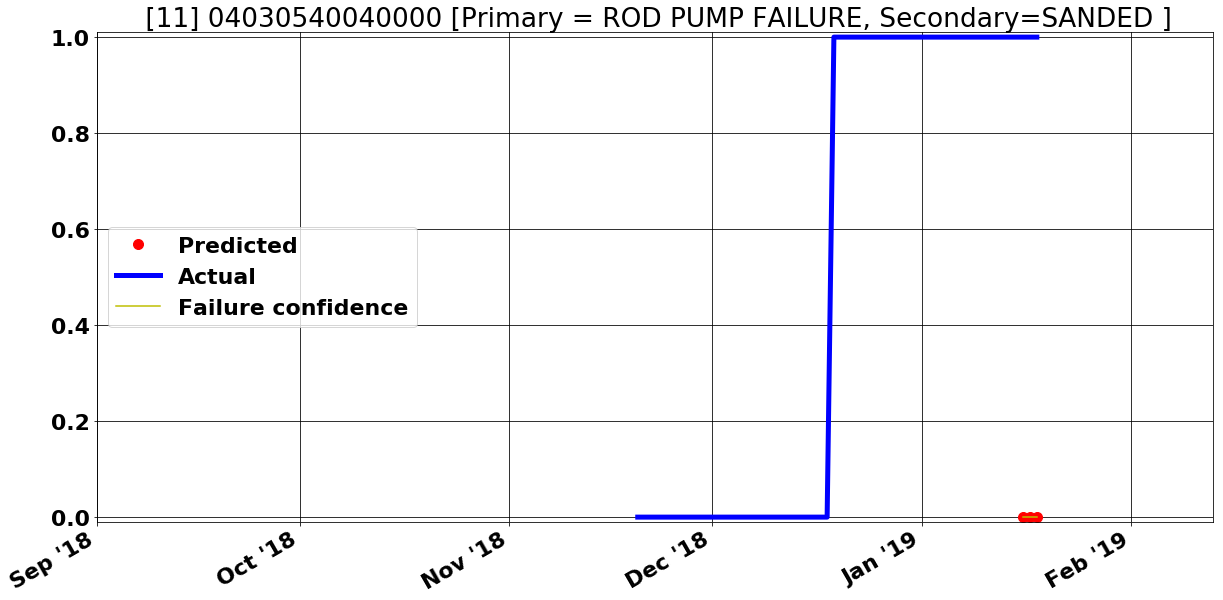

C:\Users\evaziyam\PycharmProjects\Pump-Failure-Prediction\source\failure_machine_learning.py:551: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_int[0] = 1


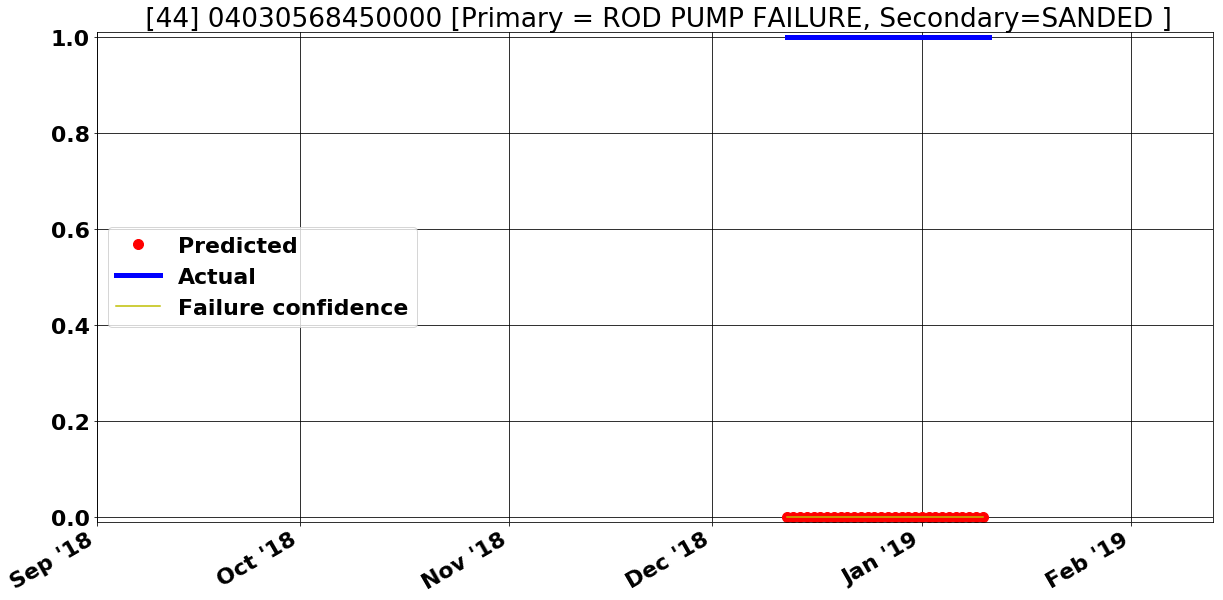

C:\Users\evaziyam\PycharmProjects\Pump-Failure-Prediction\source\failure_machine_learning.py:551: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_int[0] = 1


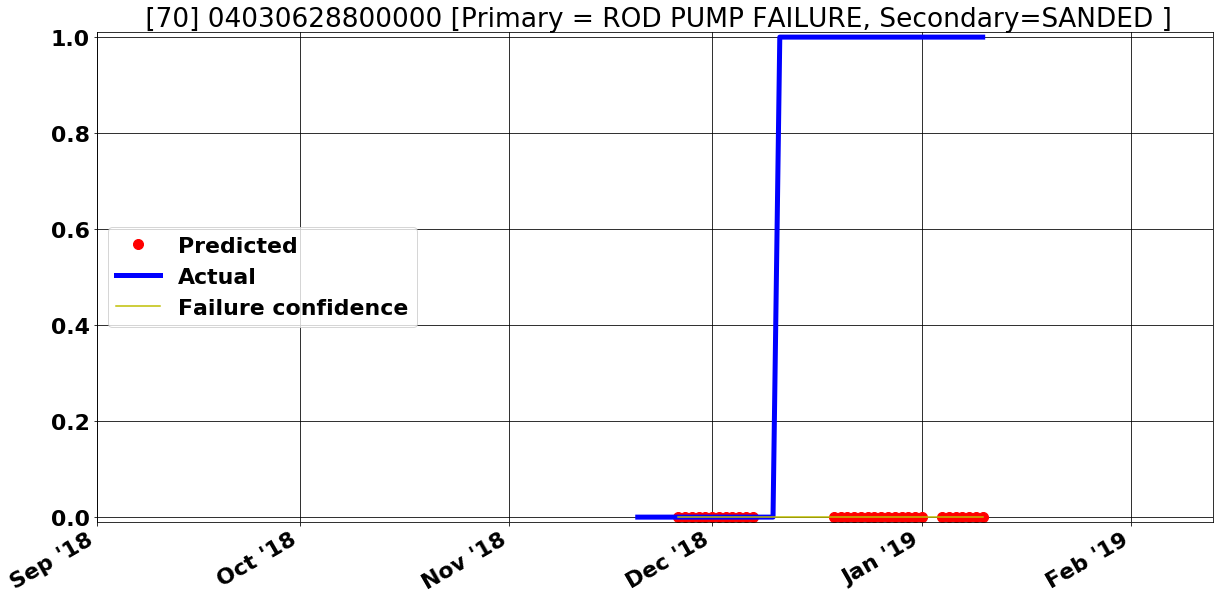

C:\Users\evaziyam\PycharmProjects\Pump-Failure-Prediction\source\failure_machine_learning.py:551: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  days_int[0] = 1


In [12]:
from source import train_module


deploy_pts_ml = { 'model_type': 'ML',
               'data_dir':data_dir,
              'run_model':True,
               'plot_test': False,
               'input_data_name':ML_failureDataSetName,
                'results_root_name':trainedModel_name}

if 'Target' in model_pars_ml['columns_all']:
    model_pars_ml['columns_all'].remove('Target')
    
date_lim = [start_date, end_date]
future_fails=[]
train_module.deploy_failure_model(model_ml, model_pars_ml, deploy_pts_ml, date_lim, future_fails)

  

# Results and Actions

In [14]:
# ML_failureDataSetName = 'new_failureDataset_1Df_1D.pkl'

# ml_model_dir = data_dir + ML_failureDataSetName
# with open(ml_model_dir, 'rb') as f:
#     data_failure_slidewin, data_failure_ts, segments_info, model_pars2 = pickle.load(f)
    
    
deploy_results_dir = deploy_pts_ml['data_dir'] + 'ML_Deploy_Results_ESOZfailureDataRF_verifiedModel.pkl'
with open(deploy_results_dir, 'rb') as f:
    failure_stat_ml, failure_results_ml, segs_ML_dict_model, seg_df_model = pickle.load(f)
    
key_segs_censored = seg_df_model[seg_df_model['PRIMARY_FAILURE']=='CENSORED'].index.tolist()
print('Number of censored segments = %d '%len(key_segs_censored))



Number of censored segments = 51 


In [16]:
min_failConf = 0
min_last_date = pd.Timestamp(2019,1,1)

keys_failCands = failure_stat_ml[ (failure_stat_ml['failure_confidence']>=min_failConf) &
                                (failure_stat_ml['last_date']>min_last_date) ].index.tolist()


fail_df = seg_df_model.loc[keys_failCands]
fail_df = fail_df.merge(failure_stat_ml,right_index=True,left_index=True) 
fail_df.shape
    

(51, 7)

# Write Sorted wells to CSV

In [14]:

fail_df.to_csv('ML_Deploy_Results_ESOZ2-14-2019.csv')
